In [5]:
from pylab import *
from scipy.ndimage import filters
def F(a): return array(a,'f')
figsize(12,6)

Let's start with a simple image processing problem: we want to
recover a sharp image from a blurred, noisy image.
We first construct a sharp image.

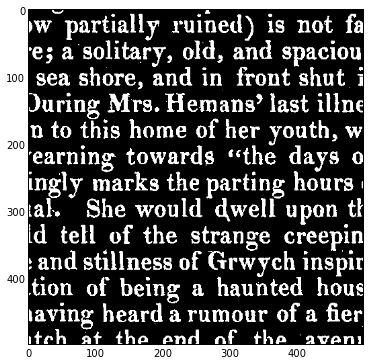

In [37]:
temp = F(mean(imread("page.png"),2))
roi = (slice(500,1000),slice(500,1000))
target = F(1-(temp[roi]>0.5))
imshow(target)

Now we artificially blur and degrade the image.

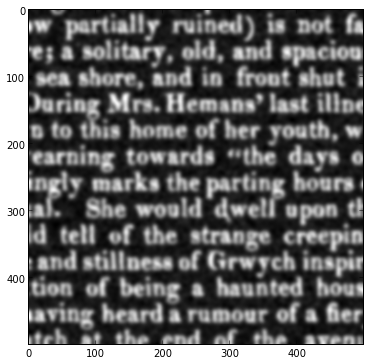

In [40]:
image = filters.gaussian_filter(target+0.2*randn(*target.shape),3.0)
image -= amin(image); image /= amax(image)
imshow(image)

The simplest convolutional neural network has no hidden layer; it is the equivalent
of a sigmoid regression.  The formula is:

$$ Y = \sigma(F*X+\theta) $$

Here

- $F$ is the filter
- $X$ is the input image
- $Y$ is the cleaned up output
- $\theta$ is a threshold

In [54]:
def sigmoid(x): return 1/(1+exp(-x))

In [55]:
r=10
filter = F(0.01*randn(2*r+1,2*r+1))

When we initialize the filter with random weights, this is
the kind of processor we get.

(0.43267395210529414, 0.50682288189825297)

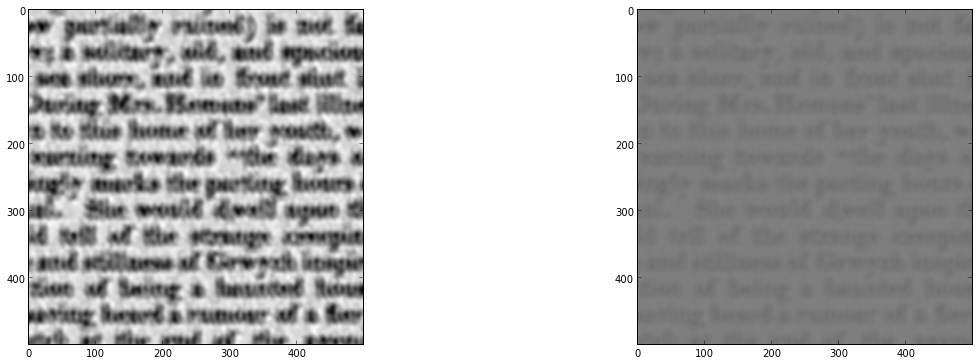

In [56]:
pred = sigmoid(filters.convolve(image,filter))
subplot(121); imshow(pred)
subplot(122); imshow(pred,vmin=0,vmax=1)
amin(pred),amax(pred)

Now, we can view the convolution basically as a large number of independent
training problems.  Consider the image $I_\hat{p}$, which is the image
$I$ shifted by $-p$.  If we keep the filter fixed and shift the image,
then the output $C$ at pixel $p$ is given by:

$$Y(p) = F \cdot X_{\hat{p}} + \theta$$

Generally, the filter $F$ has a small footprint, meaning that
it is zero outside a small region around the origin.

In essence, this problem is just like training with lots of separate
training instances, except that we're trying to use a convolution
operation to implement this.
We need to keep track of the coordinates in the right way.

$$
\begin{eqnarray}
\frac{\partial}{\partial F_{ij}} \sum_p (~T(p)-Y(p)~)^2 &=& \sum 2(T(p)-Y(p)) ~~ \sigma'(F\cdot I_{\hat{p}}) ~~ I_{\hat{p}}\\\
&=&\sum 2(T(p)-Y(p)) ~~ Y(p)(1-Y(p)) ~~ I_{\hat{p},i,j}
\end{eqnarray}
$$

Here, we define $\delta(p)$ as before:

$$ \delta(p) =  2(T(p)-Y(p)) ~~ Y(p)(1-Y(p)) $$

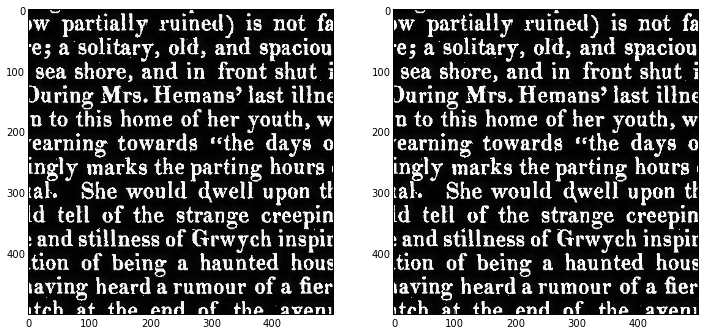

In [44]:
delta0 = (target-pred)
subplot(121); imshow(delta0)
delta = (target-pred)*pred*(1-pred)
subplot(122); imshow(delta)

This implements the update rule, the change to each individual weight.

(-0.020560804507159271, -0.0030023010284572597, dtype('float64'))

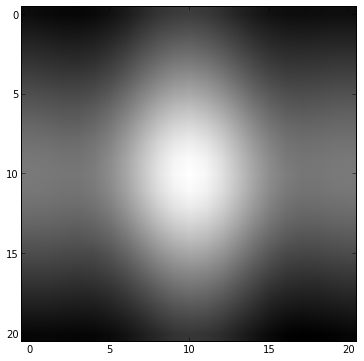

In [45]:
dw = array([[sum(delta*roll(roll(image,i,0),j,1)) for j in range(-r,r+1)] for i in range(-r,r+1)])
dw /= prod(image.shape)
imshow(dw)
amin(dw),amax(dw),dw.dtype

Now we perform the updates multiple times.
Note that this is like a batch gradient update over all pixels in the image,
so each "iter" is really more like an "epoch".

In [48]:
theta = 0.0
for iter in range(1000):
    pred = sigmoid(filters.convolve(image,filter)+theta)
    err = sum((pred-target)**2)
    delta = (pred-target)*pred*(1-pred)
    delta /= prod(image.shape)
    dw = array([[sum(delta*roll(roll(image,i,0),j,1)) for j in range(-r,r+1)] for i in range(-r,r+1)])
    if iter%50==0:
        print iter,err,":",(amin(pred),amax(pred)),sum(abs(delta)),(amin(dw),amax(dw)),(amin(filter),amax(filter)),theta
    filter -= dw
    theta -= sum(delta)

0 24760.208943 : (0.0035678377385413352, 0.9978953848980896) 0.0458853929868 (0.0053400223104518819, 0.0072862025192962669) (-0.12178462, 0.29784608) 0.0
50 20176.1372269 : (0.00066173566353980708, 0.99803984359858355) 0.0355319773236 (-0.0012748398445276302, 0.00045858820214109207) (-0.14058399, 0.36322036) -0.260421732761
100 19031.330067 : (0.00048385370845032913, 0.99854400091214424) 0.0326746901224 (-0.0010332582710076623, 0.00040143795443587651) (-0.1455725, 0.41569439) -0.454887283628
150 18198.192199 : (0.0004155409322442416, 0.99872334330467938) 0.0308582819579 (-0.00088536597466849765, 0.00036149074890512781) (-0.15812871, 0.45914328) -0.622232347642
200 17539.3167994 : (0.00038990543483953337, 0.99878464293543867) 0.0295672706387 (-0.00078260360495212408, 0.0003293243177035594) (-0.17461969, 0.50059199) -0.772475198537
250 16994.1057221 : (0.00038608381544868965, 0.99878856138959937) 0.0285879240528 (-0.00070586597014078928, 0.00030194455200845989) (-0.18923596, 0.53775758) 

As you can see, the nonlinear filter that we computed restores some of the crispness in the text.
However, it is far from a good filter; for a good filter, we really need multiple units.
In addition, we have to be very careful about scaling the inputs and the outputs, learning rates, etc.

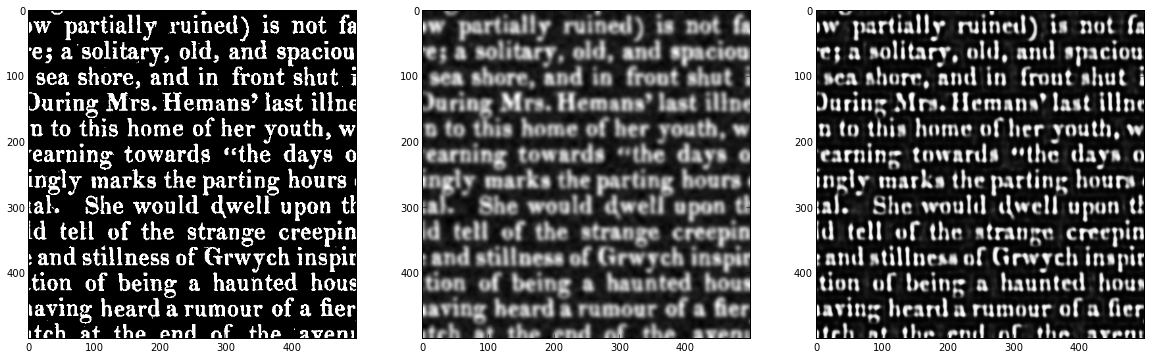

In [51]:
figsize(20,6)
subplot(131); imshow(target)
subplot(132); imshow(image)
subplot(133); imshow(sigmoid(filters.convolve(image,filter)+theta))

Looking at the filter itself is also interesting:

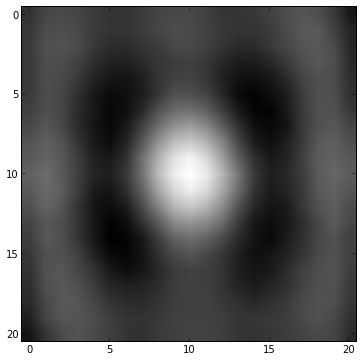

In [53]:
imshow(filter)

Note that this filter combines a number of sources of information:

- it performs a kind of deconvolution
- it also takes advantage of the statistics of the input image (hence the anisotropy)
- it depends to some degree on the absolute input values, since the sigmoid depends on that